# Detect fDOM Skyrockting Peaks

## Rules for Skyrocketing Peaks

Upward peak where: 
- Base width smaller than threshold 
- Prominence larger than a threshold 
- No adjacent upward peak in a certain range
- Both bases of the peak are not also fDOM downward peaks

## Import Tools, Load and Preprocess Data

In [34]:
# Import libraries and data 
import scipy.io as sio
import matplotlib as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import sys
sys.path.insert(1,'../')
import Tools.data_processing as dp
import Tools.data_movement as dm 
from auxiliary_functions import get_candidates, detect_flat_plat, detect_stage_rises

fDOM_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

## Get Candidate Peaks

In [11]:
prominence_range = [5,None]
width_range = [None,None]
wlen = 100
distance = 1
rel_height =.6

# Get list of all peaks that could possibly be plummeting peaks
peaks, props = find_peaks(fDOM_data[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance,
                          prominence = prominence_range,
                          width = width_range,
                          wlen = wlen,
                          rel_height = rel_height)

# Form candidate set from returned information
cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),props['prominences'][i]] for i,peak in enumerate(peaks)]

## Process proximity to other peaks in usable form

In [12]:
# Append some data to the end of cands that tell how far a peak is from other peaks (I think min of left and right should be fine)
# For each peak, determine how far it is from the closest adjacent peak
proximity_to_adjacent = np.zeros((len(peaks)))

for i in range(len(peaks)):
    x = y = fDOM_data.shape[0] + 1 
    if i > 0: 
        x = abs(peaks[i] - peaks[i-1])
    if i < len(peaks) - 1:
        y = abs(peaks[i] - peaks[i+1])
        
    proximity_to_adjacent[i] = min(x,y)


## Get Downward Peaks (used in detection mechanism) and process to usable form

In [13]:
# Flip timeseries 
flipped_fDOM = dp.flip_timeseries(copy.deepcopy(fDOM_data))

# Get fDOM plummeting peak candidate set using scipy find_peaks()
prominence_range = [3,None] # peaks must have at least prominence 3
width_range = [None,10] # peaks cannot have a base width of more than 5
wlen = 100 
distance = 1 
rel_height =.6

# Get list of all peaks that could possibly be plummeting peaks
downward_peaks, _ = find_peaks(flipped_fDOM[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance,
                          prominence = prominence_range,
                          width = width_range,
                          wlen = wlen,
                          rel_height = rel_height)

# Process into usable form: This is not efficient, but this operation is only peformed once... so no sweat 
proximity_to_downward = np.zeros((len(cands),2))

for i, cand in enumerate(cands): 
    x = y = fDOM_data.shape[0] + 1 
    
    for downward_peak in downward_peaks:
        if downward_peak <= cand[1]: 
            x = min(abs(cand[1]-downward_peak),x)
        elif downward_peak >= cand[2]:
            y = min(abs(cand[2]-downward_peak),y)
    proximity_to_downward[i,0] = x
    proximity_to_downward[i,1] = y

/var/folders/hh/m6vvts714wdcv6sngjwj41zr0000gn/T/ipykernel_923/2349065138.py:12: PeakPropertyWarning: some peaks have a prominence of 0
  downward_peaks, _ = find_peaks(flipped_fDOM[:,1],


## Import and process ground truths

In [14]:
# Import and process ground truth
truth_fname = '../Data/labeled_data/ground_truths/fDOM/fDOM_SKP/julian_time/fDOM_SKP_0k-300k.csv'

with open(truth_fname, 'r', newline = '') as f:
    
        reader = csv.reader(f, delimiter = ',')
        # truth entries in form: ['timestamp_of_peak', 'value_of_peak','label_of_peak','idx_of_peak']
        next(reader)
        truths = [[float(row[0]), float(row[1]), row[2], int(row[3])] for row in reader] 
        f.close()   

assert(len(truths) == len(cands))

## Define helper functions and set of training parameters, create training/testing splits

In [108]:
# Define Hyperparameter ranges and training parameters and helper function
iterations = 70000
num_splits = 5

basewidth_range = (1, 10)
prominence_range= (5, 20)

peak_proximity_bounds = (1,20)
downward_bases_range= (0,5) # sometimes the actual 'peak' of the downward peak is not exactly at the base of the skyrocketing peak 

accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

train_test_split_indices = TimeSeriesSplit(num_splits).split(cands)

def classify_candidate_peaks(peaks, params):
    
    def check_downward_peak_condition(index):
        left = proximity_to_downward[index,0] <= params['downward_bases_threshold']
        right = proximity_to_downward[index,1] <= params['downward_bases_threshold']
        
        if left and right: return False
        if left and not right: return True 
        return True
        
    results = []
    for i,peak in enumerate(peaks):
        
        prominence_condition = peak[3] >= params['min_prominence']
        basewidth_condition = abs(peak[1] - peak[2]) <= params['max_basewidth']
        downward_bases_condition = check_downward_peak_condition(i)
        peak_proximity_condition = proximity_to_adjacent[i] >= params['proximity_threshold']
        
        if prominence_condition and basewidth_condition and downward_bases_condition and peak_proximity_condition:
            results.append([peak[0], 'SKP'])
        else:
            results.append([peak[0], 'NSKP'])
    return results

def label_positives_negatives(predictions, truths):
    TP = TN = FP = FN = 0
    results = []
    
    for i in range(len(predictions)):
        prediction = predictions[i][1]
        truth = truths[i][2]
        
        if prediction == 'SKP':
            if truth == 'NSKP':
                FP +=1
                results.append(predictions[i].append('FP'))
            else: 
                TP +=1
                results.append(predictions[i].append('TP'))
        else:
            if truth == 'NSKP':
                TN +=1
                results.append(predictions[i].append('TN'))
            else: 
                FN +=1
                results.append(predictions[i].append('FN'))
        
    return (TP,TN,FP,FN,results)
    

## Nested Cross Validation Training Loop

In [109]:
overall_start = datetime.datetime.now()

split = 1

for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [cands[i] for i in train_val_indices], [truths[i] for i in train_val_indices]
    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]
    
    max_fold_metric = 0 
    max_result = None 
    
    print("Split: ",split)
    
    split_start = datetime.datetime.now()
    
    for iteration in range(iterations):
        
        # Random grid search for hyperparams 
        params = {}
        
        params['max_basewidth'] = np.random.randint(basewidth_range[0], basewidth_range[1]+1)
        params['min_prominence'] = np.random.uniform(prominence_range[0], prominence_range[1])
        
        params['downward_bases_threshold']= np.random.randint(downward_bases_range[0], downward_bases_range[1])
        
        params['proximity_threshold']= np.random.randint(peak_proximity_bounds[0], peak_proximity_bounds[1])
      
        predictions = classify_candidate_peaks(X_train, params)
        
        TP,TN,FP,FN,results = label_positives_negatives(predictions, y_train)
        
        if TP != 0 or FN != 0: 
            TPR = TP/(TP + FN)
            TNR = TN/(TN + FP)
        
            bal_acc = (TPR + TNR)/2

            f1_score = (2 * TP)/((2 * TP) + FP + FN)

            acc = f1_score
        acc = .0001
        if iteration and iteration % int(iterations/10) == 0: print(" {}/{} ".format(iteration, iterations), end = "")
        if acc > max_fold_metric: 
            max_fold_metric = acc
            max_result = copy.deepcopy(results)
            best_params = copy.deepcopy(params)
            
    # Test best parameters on testing data 
    test_predictions = classify_candidate_peaks(X_test, best_params)
    TP,TN,FP,FN,results = label_positives_negatives(test_predictions, y_test)
    
    
    
    if TP != 0 or FN != 0: 
        TPR = TP/(TP + FN)
        TNR = TN/(TN + FP)

        bal_acc = (TPR + TNR)/2
    else:
        bal_acc = 0 
    
    if TN != len(X_test):
        
        f1_score = (2 * TP)/((2 * TP) + FP + FN)
    else:
        f1_score = 0
        
    cfmx = confusion_matrix([row[2] for row in y_test],[row[1] for row in test_predictions], labels = ['NSKP', 'SKP'])
    print(cfmx)
    accumulated_cfmxs[split] = copy.deepcopy(cfmx)
    print('\nSplit: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, best_params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
    accumulated_test_metrics[split] = [f1_score, bal_acc] # Record test metrics of each split
    accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
    accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split
    
    split+=1

# Display Resuls 
mean_f1 = 0
mean_ba = 0 

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    mean_f1+=metrics[0]
    mean_ba+=metrics[1]

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))

print("Training time: ", datetime.datetime.now() - overall_start)

# Pickle params from last fold
with open('./Experimental_Results/fDOM_SKP/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params[num_splits], pck_file)
    pck_file.close()
    
# Pickle results from last fold 
with open('./Experimental_Results/fDOM_SKP/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle results from last fold 
with open('./Experimental_Results/fDOM_SKP/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()

Split:  1
 7000/70000  14000/70000  21000/70000  28000/70000  35000/70000  42000/70000  49000/70000  56000/70000  63000/70000 [[98  1]
 [ 6  1]]

Split: 1  F1: 0.2222 BA: 0.5664  Params: {'max_basewidth': 8, 'min_prominence': 15.721110605358579, 'downward_bases_threshold': 0, 'proximity_threshold': 4}  TP: 1 TN: 98 FP: 1 FN: 6  Time: 0:00:13.429102
Split:  2
 7000/70000  14000/70000  21000/70000  28000/70000  35000/70000  42000/70000  49000/70000  56000/70000  63000/70000 [[102   1]
 [  3   0]]

Split: 2  F1: 0.0000 BA: 0.4951  Params: {'max_basewidth': 5, 'min_prominence': 15.712383622762218, 'downward_bases_threshold': 1, 'proximity_threshold': 5}  TP: 0 TN: 102 FP: 1 FN: 3  Time: 0:00:25.897545
Split:  3
 7000/70000  14000/70000  21000/70000  28000/70000  35000/70000  42000/70000  49000/70000  56000/70000  63000/70000 [[102   0]
 [  3   1]]

Split: 3  F1: 0.4000 BA: 0.6250  Params: {'max_basewidth': 2, 'min_prominence': 12.582464389303432, 'downward_bases_threshold': 3, 'proximity_t

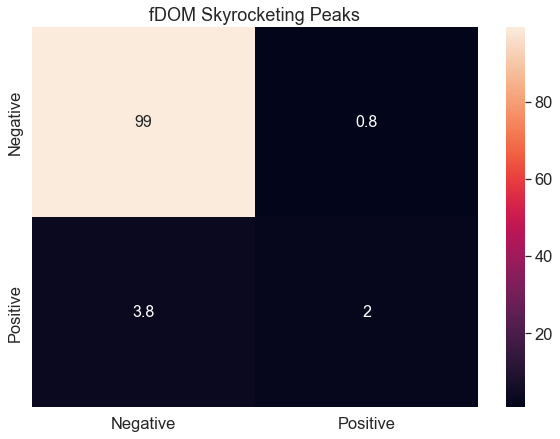

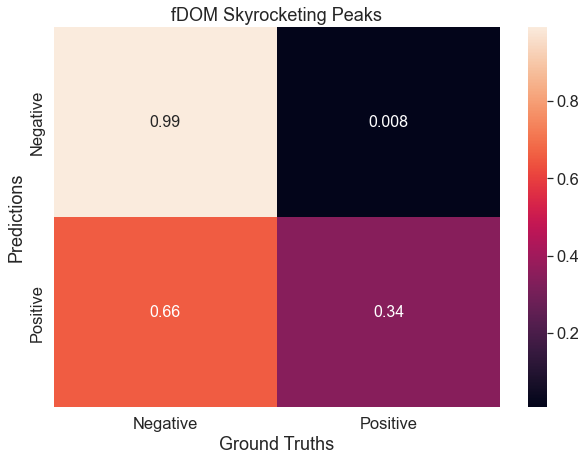

In [112]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

mean_cfmx = np.zeros((2,2))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]
mean_cfmx = mean_cfmx / num_splits



plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Skyrocketing Peaks')
sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx,index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})

plt.show()



plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Skyrocketing Peaks')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx.astype('float') / mean_cfmx.sum(axis=1)[:, np.newaxis],index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()


In [55]:
# # Filter out skyrocketing peak candidates whose left_ips or right_ips are also a plummeting peak, as we don't want to detect these
# removed = []
# not_removed = []
# for cand in fDOM_cands: 
#     if cand[1] in possible_plum_peaks or cand[2] in possible_plum_peaks:
#         removed.append(cand)
#     elif cand[1]+1 in possible_plum_peaks or cand[2]+1 in possible_plum_peaks:
#         removed.append(cand)
#     elif cand[1]-1 in possible_plum_peaks or cand[2]-1 in possible_plum_peaks:
#         removed.append(cand)
#     else:
#         not_removed.append(cand)
        
# print(len(removed))
# fDOM_cands = not_removed
# print(len(not_removed))

79
24


In [66]:
turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,cand in enumerate(fDOM_cands):
            fDOM_events.append(np.array((fDOM_data[cand[0]])))
            fDOM_lb.append(fDOM_data[math.floor(cand[1]),0])
            fDOM_rb.append(fDOM_data[math.ceil(cand[2]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(fDOM_data, fDOM_events, 'not_sky_peak', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_edge_data = dp.stage_rises_to_data(s_indices, stage_data)
stage_data_merged = dp.merge_data(stage_data, stage_edge_data, 'rise','')

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          turb_merged,
                          '../Data/temp_plotting/fDOM_sky_0k-100k.csv',
                          True,
                          True,
                          0,
                          100000)

In [ ]:
def detect_sky_peaks_fDOM(candidates: list[np.ndarray], 
                            properties: list, prom_range: 
                            list[float], base_width_range: 
                            list[float]) -> list[list[list]]:
    """
    Detect fDOM sharp peak anomalies from given set of possible candidates, given hyper parameters 
    """
    sharp_peaks = []
    not_sharp_peaks = []
    
    for i, peak in candidates:
        # Uses bases to calculate base_width. Or just use width. Is width a float or in
        base_width = properties['right_bases'][i] - properties['left_bases'][i]
        base_width = properties['widths'][i]
        prominence = properties['prominences'][i]
        start_timestamp = data[properties['left_bases'][i],0]
        end_timestamp = data[properties['right_bases'][i],0]
        peak_timestamp = data[peak][0]
        
        # Check if base_width violates
        if ((base_width > base_width_range[0] and base_width < base_width_range[1])
            and prominence > prom_range[0] and prominence < prom_range[1]):
            
            # Append [start, end, peak, label]
            sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'sharp_peak_fDOM'])
            
        else: 
            not_sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'rejected_sharp_peak_fDOM'])
    return [sharp_peaks, not_sharp_peaks]

In [28]:
# flip timeseries 
flipped_fDOM = np.array(fDOM_data)
flipped_fDOM = dp.flip_timeseries(flipped_fDOM)

# get candidates with find_peaks 
prominence_range_plum = [3,None]
width_range_plum = [None,5]
wlen_plum = 100
distance_plum = 1 
rel_height_plum =.6

# data = fDOM_raw_data[:100000][:,1]
data = flipped_fDOM[:,1]

# Get list of all peaks that could possibly be plummeting peaks
possible_plum_peaks, props = find_peaks(data,
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance_plum,
                          prominence = prominence_range_plum,
                          width = width_range_plum,
                          wlen = wlen_plum,
                          rel_height = rel_height_plum)

fDOM_cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),s_indexed[peak,0], s_indexed[peak,1] ,props['prominences'][i]] for i,peak in enumerate(possible_plum_peaks)]

# get list of turb_peaks: these turb peaks look similar to skyrocketing peaks in fDOM. 
# prominence_range_turb = [2,None]
# width_range_turb = [None,10]
# wlen_turb = 100
# distance_turb = 1 
# rel_height_turb =.8

# data = fDOM_raw_data[:100000][:,1]

# # Get list of all peaks that could possibly be sharp peaks
# turb_peaks, props = find_peaks(data,
#                           height = (None, None),
#                           threshold = (None,None),
#                           distance = distance_turb,
#                           prominence = prominence_range_turb,
#                           width = width_range_turb,
#                           wlen = wlen_turb,
#                           rel_height = rel_height_turb)

/var/folders/hh/m6vvts714wdcv6sngjwj41zr0000gn/T/ipykernel_1671/2046036813.py:16: PeakPropertyWarning: some peaks have a prominence of 0
  possible_plum_peaks, props = find_peaks(data,


In [29]:
turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,cand in enumerate(fDOM_cands):
            fDOM_events.append(np.array((flipped_fDOM[cand[0]])))
            fDOM_lb.append(flipped_fDOM[math.floor(cand[1]),0])
            fDOM_rb.append(flipped_fDOM[math.ceil(cand[2]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(flipped_fDOM, fDOM_events, 'f_opp', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_edge_data = dp.stage_rises_to_data(s_indices, stage_data)
stage_data_merged = dp.merge_data(stage_data, stage_edge_data, 'rise','')

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          dp.merge_data(fDOM_data, [], '',''),
                          '../Data/temp_plotting/fDOM_plum_0k-100k.csv',
                          True,
                          True,
                          0,
                          100000)

In [ ]:
julian_hour = 0.04166666651144624
interference_hour_range = [julian_hour * 2]
prom_range = []
base_width_range = []

plummeting_peaks, not_plummeting_peaks = detect_plum_peaks_fDOM(possible_plum_peaks,
                                                                turb_peaks,
                                                                interference_hour_range,
                                                                props)

In [ ]:
# get turb peaks 
def detect_plum_peaks_fDOM(candidates: list[np.ndarray],
                           turb_peaks: list[list[list]],
                           interference_hour_range: list[int]
                           properties: list, 
                           prom_range: list[float], 
                           base_width_range: list[float]):
    """
    Detect fDOM plummeting peak anomalies from given set of possible candidates, given hyper parameters and turb peaks
    """
    plum_peaks = []
    not_plum_peaks = []
    interference_peaks = [] # label these so we can see if it is rejecting correctly
    
    for i, peak in candidates:
        # Uses bases to calculate base_width. Or just use width. Is width a float or in
        base_width = properties['right_bases'][i] - properties['left_bases'][i]
        base_width = properties['widths'][i]
        prominence = properties['prominences'][i]
        start_timestamp = data[properties['left_bases'][i],0]
        end_timestamp = data[properties['right_bases'][i],0]
        peak_timestamp = data[peak][0]
        
        # Check if base_width violates
        if ((base_width > base_width_range[0] and base_width < base_width_range[1])
            and prominence > prom_range[0] and prominence < prom_range[1]):
            
            # Check for interference
            for peak in turb_peaks: 
                # Check if fDOM peak is within x hours of turb peak
                if condition: 
                    # Append to interference_peaks
                    break
            # Append [start, end, peak, label]
            plum_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'plum_peak_fDOM'])
            
        else: 
            not_sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'rejected_plum_peak_fDOM'])
    return sharp_peaks, not_sharp_peaks
    
    pass

In [ ]:
plum_peaks = []
def filter_fDOM_cands(peaks, props,fDOM_data):
    """
    Filter out candidates with an extremely small ending slope 
    Filter out candidates whose start and end occur on a plummenting peak/interference
    """
    take_indices = []
    
    end_thresh = .2
    for i, peak in enumerate(peaks): 
        if peak > 100000:
            break
        end_run = abs(peak - math.ceil(props['right_ips'][i]))
        end_rise = abs(fDOM_data[peak,1] - fDOM_data[math.ceil(props['right_ips'][i]),1])  
        end_slope = end_rise/end_run

        if end_slope < end_thresh:
            print('Date: {} ES: {}  Prom: {}'.format(dp.julian_to_datetime(fDOM_data[peak,0]), round(end_slope,3),round(props['prominences'][i],2)))
            print('Left IPS: {}'.format(dp.julian_to_datetime(fDOM_data[math.ceil(props['right_ips'][i]),0])))
            print('\n')
        
        if math.ceil(props['right_ips'][i]) in plum_peaks and math.floor(props['left_ips'][i]) in plum_peaks:
            print('DQP: Data: {}'.format(dp.julian_to_datetime(fDOM_data[peak,0])))
        
filter_fDOM_cands(fDOM_peaks, fDOM_props, fDOM_raw_data)

flipped_fDOM = np.array(fDOM_raw_data)
flipped_fDOM = dp.flip_timeseries(flipped_fDOM)